In [18]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

def get_user_agent_string(first_name : str, last_name : str, email : str) -> str:
    return f'{first_name} {last_name} ({email})'

def get_cik_ticker_map(user_agent_string : str) -> dict:

    headers = {
        'User-Agent': user_agent_string
    }

    # Download the CIK mapping file
    cik_map_url = "https://www.sec.gov/include/ticker.txt"
    response = requests.get(cik_map_url, headers=headers, timeout=10)

    if response.status_code == 200:
        # Store the CIK mapping in the Edgar class as a dictionary
        cik_map = {}
        for line in response.text.splitlines():
            ticker, cik = line.split('\t')
            # Pad the CIK with leading zeros to ensure it's 10 digits long
            padded_cik = cik.zfill(10)
            cik_map[ticker.lower()] = padded_cik
        print("CIK mapping downloaded successfully.")
        return cik_map
    else:
        print(f"Failed to download CIK mapping. Status code: {response.status_code}")
        return 
        
def get_cik_from_ticker(ticker : str, cik_map : dict) -> str:
    ticker = ticker.lower()
    return cik_map[ticker]

def get_dict(path : str):
    with open(path, 'r') as file:
        my_dict = json.load(file)
    return my_dict

def save_dict(my_dict : dict, path : str):
    with open(path, 'w') as file:
        json.dump(my_dict, file)


def get_data_by_tag(user_agent_string : str, cik : str, tag : str, taxonomy : str = "us-gaap") -> dict:
    headers = {
        'User-Agent': user_agent_string
    }
    url = f'https://data.sec.gov/api/xbrl/companyconcept/CIK{cik}/{taxonomy}/{tag}.json'
    response = requests.get(url, headers=headers, timeout=10)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error: {response.status_code}")
        return None

def get_company_data(
    user_agent_string : str,
    cik : str,
    tags_dict : str,
    taxonomy : str = "us-gaap"
    ):

    historical_data = {}

    for key in tqdm(tags_dict.keys(), desc="Getting data by tag"):

        data = get_data_by_tag(
            user_agent_string,
            cik,
            key,
        )

        historical_data[key] = data
    
    return historical_data

def get_data_by_tag(data_obj : dict, tag : str):
    data = []
    for item in data_obj[tag]['units']['USD']:
        data.append((item['end'], item['val']))
    return data

def plot(data : list[tuple[str, float]], title : str, path : str):

    dates = [datetime.strptime(date, '%Y-%m-%d') for date, _ in data]
    values = [value for _, value in data]
    
    # Extract dates and values from the data
    dates = [datetime.strptime(date, '%Y-%m-%d') for date, _ in hi]
    values = [value for _, value in hi]

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(dates, values, marker='o')

    # Customize the plot
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)

    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()

    # Use a tight layout to prevent the x-label from being cut off
    plt.tight_layout()

    # Display the plot
    plt.savefig(path)

In [2]:
user_agent_string = get_user_agent_string("Ingimar", "Tomasson", "ingitom99@gmail.com")

In [3]:
cik_map = get_cik_ticker_map(user_agent_string)

CIK mapping downloaded successfully.


In [4]:
cik = get_cik_from_ticker("AAPL", cik_map)

In [5]:
data = get_data_by_tag(user_agent_string, cik, "AccountsPayableCurrent")

In [6]:
tags_dict = get_dict("./tags.json")

In [7]:
historical_appl_data = get_company_data(
    user_agent_string,
    cik,
    tags_dict
)

Getting data by tag:   0%|          | 0/498 [00:00<?, ?it/s]

Getting data by tag: 100%|██████████| 498/498 [02:14<00:00,  3.72it/s]


In [8]:
save_dict(historical_appl_data, "./historical_appl_data.json")

In [13]:
historical_appl_data['AccruedLiabilitiesCurrent']

{'cik': 320193,
 'taxonomy': 'us-gaap',
 'tag': 'AccruedLiabilitiesCurrent',
 'label': 'Accrued Liabilities, Current',
 'description': 'Carrying value as of the balance sheet date of obligations incurred and payable, pertaining to costs that are statutory in nature, are incurred on contractual obligations, or accumulate over time and for which invoices have not yet been received or will not be rendered. Examples include taxes, interest, rent and utilities. Used to reflect the current portion of the liabilities (due within one year or within the normal operating cycle if longer).',
 'entityName': 'Apple Inc.',
 'units': {'USD': [{'end': '2008-09-27',
    'val': 4224000000,
    'accn': '0001193125-10-012091',
    'fy': 2009,
    'fp': 'FY',
    'form': '10-K/A',
    'filed': '2010-01-25',
    'frame': 'CY2008Q3I'},
   {'end': '2008-09-27',
    'val': 3719000000,
    'accn': '0001193125-09-214859',
    'fy': 2009,
    'fp': 'FY',
    'form': '10-K',
    'filed': '2009-10-27'},
   {'end': 

In [19]:
hi = get_data_by_tag(historical_appl_data, "AccruedLiabilitiesCurrent")

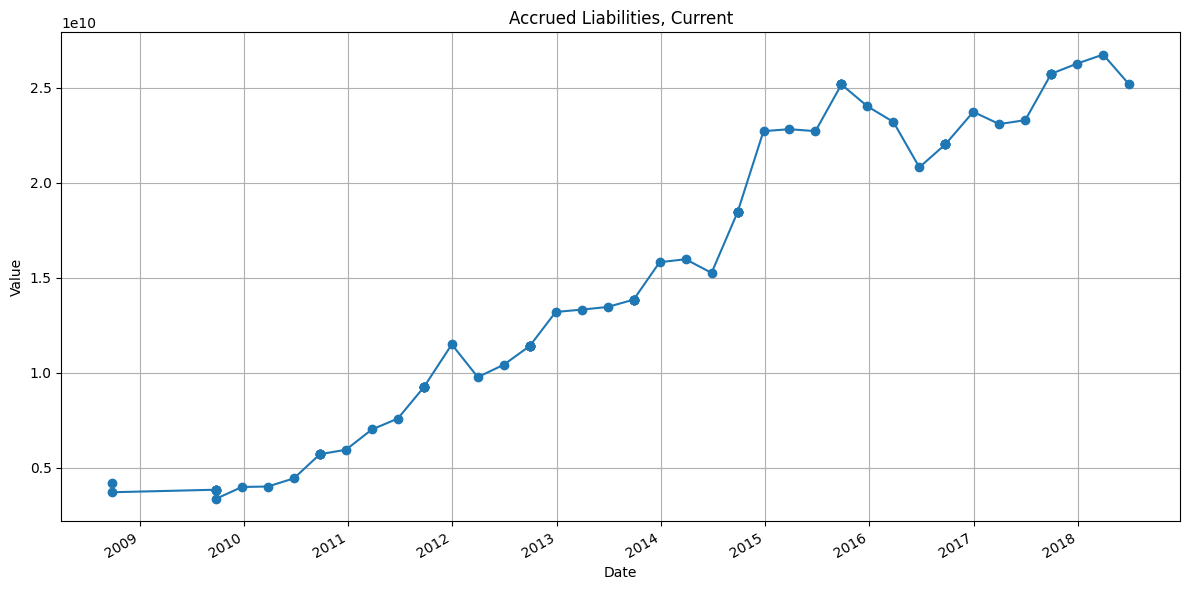

In [23]:
import matplotlib.pyplot as plt
from datetime import datetime

# Extract dates and values from the data
dates = [datetime.strptime(date, '%Y-%m-%d') for date, _ in hi]
values = [value for _, value in hi]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(dates, values, marker='o')

# Customize the plot
plt.title('Accrued Liabilities, Current')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Use a tight layout to prevent the x-label from being cut off
plt.tight_layout()

# Display the plot
plt.show()
